# BBC Archive (public project) - Yahya Alnwsany

In [1]:
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

2024-01-31 19:26:26.986362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 19:26:26.986545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 19:26:27.186850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
with open("/kaggle/input/bbc-archive/bbc-text.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

category,text

Each data point looks like this:

tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially

In [3]:
# variables we will need with padding and sequence (Tokenization)

NUM_WORDS = 1000                   # the size of words in the voc
EMBEDDING_DIM = 16                 #dim of the embedding which set to 16
MAXLEN = 120                      #max lenght of sequence for senctece
PADDING = 'post'                  #truncating which set to post 
OOV_TOKEN = "<OOV>"              #unkown words(out the vocab)
TRAINING_SPLIT = .8              #size of training which set to 80% of data

# preprocessing on the data

what of the most important steps to make data ready for fitting 
extract the sentences and the labels in the file 
we will preprocess on the which remove stop words and split the data into train/val

In [4]:

def remove_stopwords(sentence):
    
     #sentence (string): sentence to remove the stopwords from
    
    
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am","an", "and", "any", "are", "as", "at", "be", "because", "been", 
                 "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for","from", "further", "had", "has", "have", "having", "he", "he'd", "he'll","he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his","how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is""it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself",
                 "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves","out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some",  "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this","those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    
    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence


In [5]:
def parse_data_from_file(filename):
    
    #Extracts sentences and labels from a CSV file
    
    sentences = []   
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, labels

In [6]:
sentences, labels = parse_data_from_file("/kaggle/input/bbc-archive/bbc-text.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 2225 sentences in the dataset.

First sentence has 454 words (after removing stopwords).

There are 2225 labels in the dataset.

The first 5 labels are ['tech', 'business', 'sport', 'sport', 'entertainment']


In [7]:
def train_val_split(sentences, labels, training_split):
    
    
    
    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(training_split * len(sentences))

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [8]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 1780 sentences for training.

There are 1780 labels for training.

There are 445 sentences for validation.

There are 445 labels for validation.


we start steps of nlp as tokenization the sentences

In [9]:
def fit_tokenizer(train_sentences, num_words, oov_token):

    
    #the Tokenizer class
    tokenizer = Tokenizer(num_words = num_words , oov_token = oov_token)
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

In [10]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 27285 words

<OOV> token included in vocabulary


convert the sentece to sequence and convert the seq to padd

In [11]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
  
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences , maxlen = maxlen , padding = padding )
    
   
    
    return padded_sequences

In [12]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (1780, 120)

Padded validation sequences have shape: (445, 120)


In [13]:

def tokenize_labels(all_labels, split_labels):

    # Instantiate the Tokenizer 
    label_tokenizer = Tokenizer()
    
    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)
   
    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
    # Convert sequences to a numpy array
    label_seq_np = np.array(label_seq) - 1
    
  
    
    return label_seq_np

In [14]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[3]
 [1]
 [0]
 [0]
 [4]]

First 5 labels of the validation set should look like this:
[[4]
 [3]
 [2]
 [0]
 [0]]

Tokenized labels of the training set have shape: (1780, 1)

Tokenized labels of the validation set have shape: (445, 1)



# the model
oh here we are let's create our model to fit the data

the model involve Embedding as first layer


***GlobalAveragePooling1D as second layer which you can find the describtion of how it work down****
     
 ***as output layer Dense with 5 neurons cuz we have 5 labels with softmax as activation***

In [15]:
def create_model(num_words, embedding_dim, maxlen):
 
    tf.random.set_seed(123)

    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(units=5, activation='softmax') 
    ])
    
    model.compile(loss= 'sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    return model

In [16]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
56/56 [==============================] - 1s 8ms/step - loss: 1.5995 - accuracy: 0.2596 - val_loss: 1.5866 - val_accuracy: 0.4135
Epoch 2/30
56/56 [==============================] - 0s 4ms/step - loss: 1.5719 - accuracy: 0.4534 - val_loss: 1.5570 - val_accuracy: 0.4607
Epoch 3/30
56/56 [==============================] - 0s 4ms/step - loss: 1.5338 - accuracy: 0.4691 - val_loss: 1.5161 - val_accuracy: 0.4854
Epoch 4/30
56/56 [==============================] - 0s 4ms/step - loss: 1.4821 - accuracy: 0.5051 - val_loss: 1.4625 - val_accuracy: 0.5281
Epoch 5/30
56/56 [==============================] - 0s 4ms/step - loss: 1.4169 - accuracy: 0.5848 - val_loss: 1.3982 - val_accuracy: 0.5865
Epoch 6/30
56/56 [==============================] - 0s 4ms/step - loss: 1.3403 - accuracy: 0.6539 - val_loss: 1.3231 - val_accuracy: 0.6652
Epoch 7/30
56/56 [==============================] - 0s 4ms/step - loss: 1.2549 - accuracy: 0.7618 - val_loss: 1.2419 - val_accuracy: 0.7596
Epoch 8/30
56/56 [==

In [17]:

def predict_sport_class(sentence, tokenizer, padding, max_len):
    # Convert the sentence to a padded sequence
    sentence_seq = seq_and_pad([sentence], tokenizer, padding, max_len)
    
    # Make a prediction
    prediction = model.predict(sentence_seq)
    
    # Get the predicted label
    predicted_label = np.argmax(prediction)
    
    # Mapping the label value back to the original label
    label_mapping = {0: "sport", 1: "business", 2: "politics", 3: "tech", 4: "entertainment"}
    
    # Get the predicted class label
    predicted_class = label_mapping[predicted_label]
    
    return predicted_class

# predict

***so let's test our model and see how it's work ,
you can edit the article and input a new one to see which class belong to***

In [18]:

new_article = "It was a very, very tough match,” Sinner said in his on-court interview. “I started off really well. He missed for two sets, I felt like he was not feeling that great on court, so I just tried to keep pushing.”You have to go all the way back to his fourth-round defeat against Chung Hyeon in 2018 for the previous time that Djokovic lost in Melbourne – 33 matches ago.‘Nole’ later gave a very frank assessment of his performance against Sinner, which was also his first semifinal defeat at the Australian Open.“He outplayed me completely today,” Djokovic told reporters. “Look, I was, in a way, shocked with my level, in a bad way. There was not much I was doing right in the first two sets."

predicted_class = predict_sport_class(new_article, tokenizer, PADDING, MAXLEN)

print("The predicted class is:", predicted_class)


1/1 [==============================] - 0s 94ms/step
The predicted class is: sport


***let's see how our model work as plot***

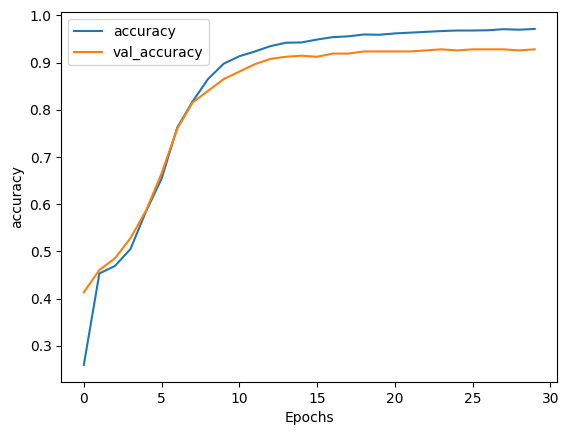

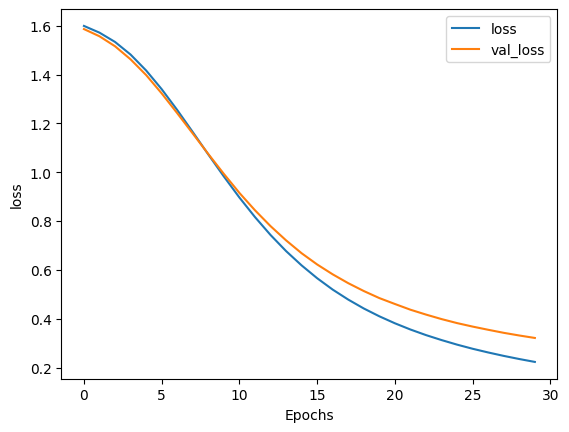

In [19]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# thanks..i hope you liked